# 360. IMDB Sentiment Analysis
- LSTM을 사용하여 IMDB 데이터 세트에 대한 감정 분석을 진행합니다.

- IMDB (Internet Movie Database, https://www.imdb.com/)  Dataset
    - 각 25,000 개의 training/testing set 으로 구성된 IMDB 영화관람평  

    - `imdb_reviews` – encoding 되어있지 않은 string 형태의 data  

    - label : positive, negative binary classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

- 데이터 다운로드

In [2]:
# IMDb 리뷰 데이터셋을 로드하고, 데이터셋 정보도 함께 가져옴
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# TensorFlow 텐서를 파이썬 데이터 타입으로 변환하여 리스트에 저장
reviews = []
sentiments = []
for review, sentiment in dataset['train']:
    reviews.append(review.numpy().decode('utf-8'))  # 텐서를 문자열로 변환
    sentiments.append(sentiment.numpy())  # 텐서를 정수로 변환

# pandas DataFrame 생성
df = pd.DataFrame({'review': reviews, 'sentiment': sentiments})

# CSV 파일로 저장
df.to_csv('IMDB_dataset.csv', index=False)

In [3]:
df = pd.read_csv("IMDB_dataset.csv")
print(df.shape)
df.head()

(25000, 2)


,review,sentiment
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1


In [4]:
df['sentiment'].value_counts()

sentiment
0    12500
1    12500
Name: count, dtype: int64

### train / test set 분할

In [5]:
# 데이터셋을 입력(X)과 레이블(y)로 분할
X = df['review'].values
y = df['sentiment'].values

# 훈련 데이터와 테스트 데이터로 분할
train_sentences, test_sentences, train_labels, test_labels = \
                train_test_split(X, y, test_size=0.2, random_state=0)

# 데이터셋의 크기 출력
train_sentences.shape, test_sentences.shape, train_labels.shape, test_labels.shape

((20000,), (5000,), (20000,), (5000,))

## keras.preprocessing module 을 이용하여 tokenize 및 padding
- keras.preprocessing.text.Tokenizer  
    - 문장을 tokenize

- keras.preprocessing.sequence.pad_sequence
    - 동일한 길이의 입력으로 truncate/pad

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000  # 단어의 최대 개수

# 토크나이저 객체 생성 및 훈련 데이터에 대해 적합화
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train_sentences)

- tokenizer의 dictionary를 이용하여 text 를 integer의 sequence로 변환

In [7]:
# 훈련 데이터와 테스트 데이터를 정수 시퀀스로 변환
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)
print(train_sentences[0])
print(train_sequences[0])

This show is possibly the biggest, ugliest, most generic steam pile I've seen in children's programming that's actually become successful. The lead character, Johnny, while I understand he's supposed to represent an ordinary kid, isn't likable or even tolerable. The jokes are lame, overdone (i.e. the "Whoa! Didn't see that coming" gag. Come on, that wasn't even funny the first time. It's not even cute) and lack any form of primitive wit or inspiration. And lastly... it's just plain ugly to look at. While kids aren't especially critical of artistic talent, they still prefer eye candy. I can't stand watching the show, because in a way, the art style is just...gross. Hideous, in fact. Just plain crummy. <br /><br />I just can't stand that this is getting so much airtime. While I understand that nostalgia can be a little irrational and I shouldn't be getting my hopes up on it coming back... I really miss the old cartoons. Bring back Dexter's Laboratory, The Powerpuff Girls... anything but 

- sentence length 분포 시각화

가장 긴 문장 길이 : 2493
평균 문장 길이 : 238.181


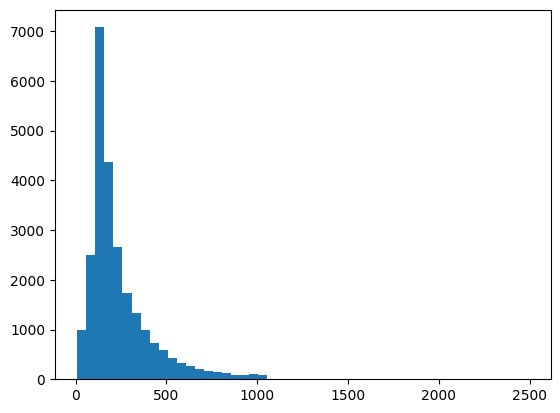

In [8]:
# 훈련 데이터와 테스트 데이터의 시퀀스 길이를 결합하여 히스토그램을 생성
plt.hist([len(s) for s in train_sequences] + [len(s) for s in test_sequences], bins=50)

print('가장 긴 문장 길이 : {}'.format(max([len(s) for s in train_sequences])))
print('평균 문장 길이 : {}'.format(sum([len(s) for s in train_sequences])/len(train_sequences)))

### Padding
- 전체 sequence 를 동일한 길이로 통일

In [9]:
max_length = 300  # 시퀀스의 최대 길이

# 훈련 데이터와 테스트 데이터를 패딩하여 시퀀스의 길이를 최대 길이에 맞춤
train_padded = pad_sequences(train_sequences, maxlen=max_length,
                             truncating='post', padding='post')

test_padded = pad_sequences(test_sequences, maxlen=max_length,
                            truncating='post', padding='post')

print(train_padded.shape)
print(test_padded.shape)
print(train_padded[0])

(20000, 300)
(5000, 300)
[  12  121    7  855    2 1105    1   88 3869 6398 2467  206  109    9
 2815 8296  195  159  410 1109    2  484  108 1803  135   11  387  238
  419    6 4165   33 2028  556  217 1477   40   57 6952    2  642   24
  841 3613   11  941    2    1  160   65   13  588 3206  220   21   13
  289   57  161    2   80   58   43   22   57 1021    3  577  101  809
    5 5137 2205   40 2916    3 7544   43   41 1032 1532    6  166   31
  135  356  719  263 2730    5 1611  671   34  129 2694  723 1916   11
  188  757  147    2  121   84    9    4   95    2  497  402    7   41
 2667 4456    9  187   41 1032 9570    8    8   11   41  188  757   13
   12    7  385   36   74    1  135   11  387   13 4413   68   27    4
  114 9114    3   11 1563   27  385   59 1880   54   21   10  588  142
   11   64  706    2  152 2396  733  142    1 7676    2    1  544  232
   19   12  602   11  480   43   41    1  526  150    8    8  329  274
   11 4645   23   90  445  127   58   21   12  121  

- sequence data 를 sentence 로 reverse conversion 하여 sequence 변환이 잘 되었는지 확인

In [10]:
text = train_padded[0]

# 정수 시퀀스를 다시 단어로 변환하여 출력
print(' '.join([tokenizer.index_word.get(i, '<pad>') for i in text]))
print()

# 원본 텍스트 출력
print(train_sentences[0])

this show is possibly the biggest <OOV> most generic steam pile i've seen in children's programming that's actually become successful the lead character johnny while i understand he's supposed to represent an ordinary kid isn't likable or even tolerable the jokes are lame overdone i e the <OOV> didn't see that coming gag come on that wasn't even funny the first time it's not even cute and lack any form of primitive wit or inspiration and lastly it's just plain ugly to look at while kids aren't especially critical of artistic talent they still prefer eye candy i can't stand watching the show because in a way the art style is just gross hideous in fact just plain crummy br br i just can't stand that this is getting so much <OOV> while i understand that nostalgia can be a little irrational and i shouldn't be getting my hopes up on it coming back i really miss the old cartoons bring back <OOV> laboratory the <OOV> girls anything but this crap i guess it's just <OOV> thinking though br br s

### `TensorDataset`을 이용하여 numpy sequence data 를 tensor dataloader 로 변환

In [11]:
# Tensor 데이터셋 생성
train_data = TensorDataset(torch.LongTensor(train_padded), torch.FloatTensor(train_labels))
valid_data = TensorDataset(torch.LongTensor(test_padded), torch.FloatTensor(test_labels))

# 데이터로더 생성
batch_size = 50  # 배치 크기 설정

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)

In [12]:
# training data의 batch 한 개 출력
sample_X, sample_y = next(iter(train_loader))

print('Sample input size:', sample_X.size()) # batch_size, seq_length
print('Sample label size:', sample_y.size())

Sample input size: torch.Size([50, 300])
Sample label size: torch.Size([50])


### Model 생성

- 감성 분석 이진 분류 모델

<img src="https://miro.medium.com/max/875/1*SICYykT7ybua1gVJDNlajw.png"  width=600 />

In [13]:
class SentimentRNN(nn.Module):
    def __init__(self, no_layers, vocab_size, embedding_dim,
                         hidden_dim, output_dim, drop_prob=0.3):
        super(SentimentRNN, self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # 임베딩 레이어: 단어의 인덱스를 고정된 크기의 벡터로 변환합니다.
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM 레이어: LSTM 네트워크를 정의합니다.
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim,
                            num_layers=no_layers, batch_first=True)

        # 드롭아웃 레이어: 과적합을 방지하기 위해 일부 뉴런을 무작위로 비활성화합니다.
        self.dropout = nn.Dropout(drop_prob)

        # 완전 연결 레이어: LSTM의 출력을 최종 출력 크기로 변환합니다.
        self.fc = nn.Linear(hidden_dim, output_dim)

        # 시그모이드 활성화 함수: 이진 분류 문제를 위한 활성화 함수입니다.
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)

        # 입력 데이터를 임베딩하여 변환합니다.
        embeds = self.embedding(x)

        # LSTM 레이어에 임베딩된 데이터를 전달하여 순방향 전파를 수행합니다.
        lstm_out, hidden = self.lstm(embeds, hidden)

        # 드롭아웃을 적용합니다.
        out = self.dropout(lstm_out)

        # 완전 연결 레이어를 통해 출력을 생성합니다.
        out = self.fc(out)

        # 시그모이드 활성화 함수를 통해 확률 값을 생성합니다.
        sig_out = self.sig(out)

        # many-to-one 아키텍처에서 마지막 스텝의 출력과 hidden 상태를 반환합니다.
        return sig_out[:, -1], hidden

    def init_hidden(self, batch_size):
        ''' 은닉 상태 초기화 '''
        # 은닉 상태와 셀 상태를 0으로 초기화합니다.
        h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        return (h0, c0)

In [14]:
no_layers = 1             # LSTM 레이어의 수
vocab_size = vocab_size + 1    # 패딩을 위한 단어 하나 추가
embedding_dim = 64     # 임베딩 차원
output_dim = 1              # 출력 차원
hidden_dim = 256         # LSTM 은닉 상태의 차원

# SentimentRNN 모델 인스턴스 생성
model = SentimentRNN(no_layers, vocab_size, embedding_dim,
                     hidden_dim, output_dim, drop_prob=0.3)

# 모델을 지정한 장치로 이동
model.to(device)

SentimentRNN(
  (embedding): Embedding(10001, 64)
  (lstm): LSTM(64, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

### Training

In [15]:
lr = 0.001  # 학습률 설정

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 정확도 계산을 위한 보조 함수
def acc(pred, label):
    # 예측값을 반올림하여 이진 분류 결과로 변환
    pred = torch.round(pred.squeeze())
    # 정확하게 예측된 개수 반환
    return torch.sum(pred == label.squeeze()).item()

In [16]:
import time
s = time.time()
clip = 5          # 그래디언트 클리핑 임계값
epochs = 10  # 에폭 수
valid_loss_min = np.inf         # 최소 검증 손실 초기화

LOSS, VAL_LOSS, ACC, VAL_ACC = [], [], [], []

# 각 에폭마다 훈련 및 검증을 수행
for epoch in range(epochs):
    model.train()      # 모델을 훈련 모드로 설정

    train_loss = 0  # 훈련 손실 초기화
    train_acc = 0   # 훈련 정확도 초기화
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # 그래디언트 초기화

        inputs, labels = inputs.to(device), labels.to(device)

        # 은닉 상태 초기화
        h = model.init_hidden(batch_size)

        # 순방향 전파
        output, hidden = model(inputs, h)

        # 손실 계산
        loss = criterion(output.squeeze(), labels)

        train_loss += loss.item()             # 훈련 손실 누적
        accuracy = acc(output, labels)    # 정확도 계산
        train_acc += accuracy                # 훈련 정확도 누적

        loss.backward()  # 역전파 수행
        # 순환 신경망을 학습할 때는 기울기 클리핑을 적용하는 것이 좋습니다.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()  # 매개변수 업데이트

    # 평균 손실 및 정확도 계산
    train_loss = train_loss / len(train_data)
    train_acc = train_acc / len(train_data)
    LOSS.append(train_loss)
    ACC.append(train_acc)

    # 검증 모드로 전환
    model.eval()

    val_loss = 0  # 검증 손실 초기화
    val_acc = 0   # 검증 정확도 초기화
    for inputs, labels in valid_loader:

            inputs, labels = inputs.to(device), labels.to(device)

            # 은닉 상태 초기화
            h = model.init_hidden(batch_size)
            # 순방향 전파
            output, hidden = model(inputs, h)
            # 손실 계산
            loss = criterion(output.squeeze(), labels)

            val_loss +=  loss.item()             # 검증 손실 누적
            accuracy = acc(output, labels)  # 정확도 계산
            val_acc += accuracy                 # 검증 정확도 누적

    # 평균 검증 손실 및 정확도 계산
    val_loss = val_loss / len(valid_data)
    val_acc = val_acc / len(valid_data)
    VAL_LOSS.append(val_loss)
    VAL_ACC.append(val_acc)

    # 에폭 결과 출력
    print(f'epoch {epoch} ==> train loss: {train_loss:.5f},  validation loss: {val_loss:.5f}',
                                            f'train acc: {train_acc:.5f}, validation acc: {val_acc:.5f}')

    # 검증 손실이 최소값을 갱신했을 때 모델 저장
    if val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('model saved.............')
        valid_loss_min = val_loss

# 걸린 시간 출력
print((time.time() - s)/60)

epoch 0 ==> train loss: 0.01390,  validation loss: 0.01385 train acc: 0.50015, validation acc: 0.49860
model saved.............
epoch 1 ==> train loss: 0.01383,  validation loss: 0.01387 train acc: 0.51300, validation acc: 0.50600
epoch 2 ==> train loss: 0.01375,  validation loss: 0.01389 train acc: 0.51995, validation acc: 0.51960
epoch 3 ==> train loss: 0.01342,  validation loss: 0.01409 train acc: 0.54070, validation acc: 0.51040
epoch 4 ==> train loss: 0.01287,  validation loss: 0.01442 train acc: 0.56095, validation acc: 0.50680
epoch 5 ==> train loss: 0.01209,  validation loss: 0.01547 train acc: 0.59020, validation acc: 0.50340
epoch 6 ==> train loss: 0.01130,  validation loss: 0.01668 train acc: 0.60820, validation acc: 0.52560
epoch 7 ==> train loss: 0.01035,  validation loss: 0.01517 train acc: 0.69425, validation acc: 0.66060
epoch 8 ==> train loss: 0.00839,  validation loss: 0.01412 train acc: 0.81575, validation acc: 0.71840
epoch 9 ==> train loss: 0.00619,  validation los

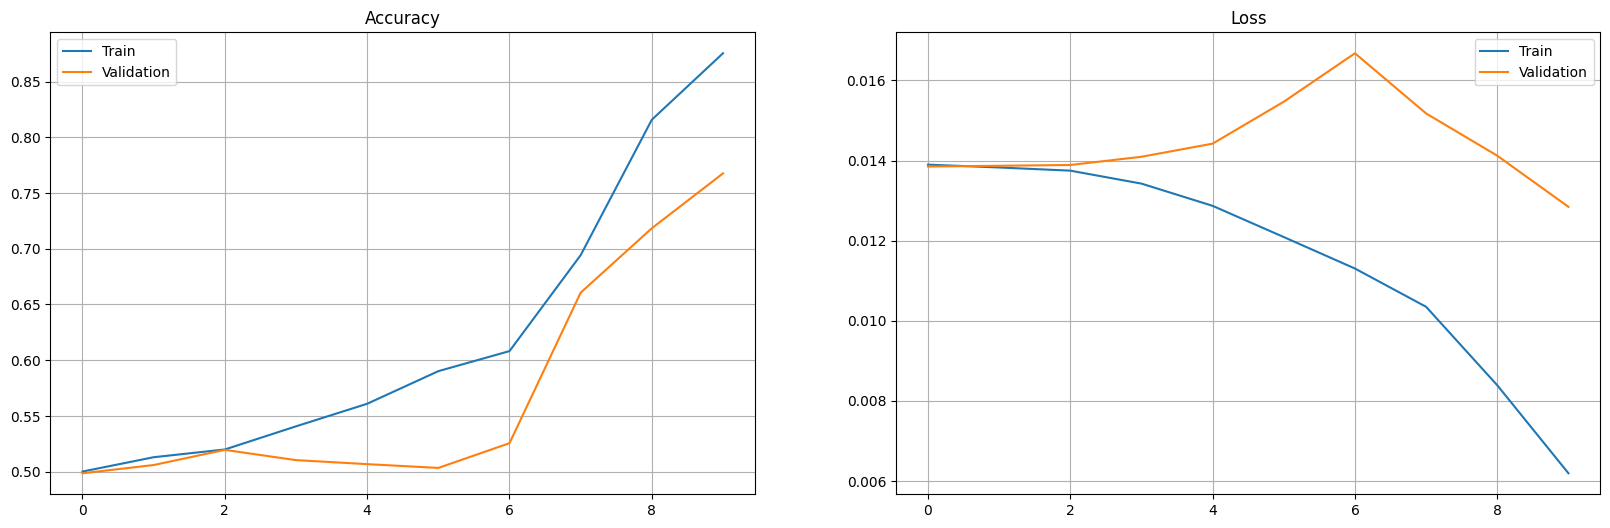

In [17]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(ACC, label='Train')
plt.plot(VAL_ACC, label='Validation')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(LOSS, label='Train')
plt.plot(VAL_LOSS, label='Validation')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

### Inferance

In [18]:
def predict_text(text):
    # 입력 텍스트를 정수 시퀀스로 변환하고 패딩
    sequences = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequences, maxlen=max_length,
                            truncating='post', padding='post')
    # 텐서로 변환하고 지정한 장치로 이동
    inputs = torch.tensor(padded).to(device)
    # 초기 은닉 상태 생성
    h = model.init_hidden(1)
    # 모델에 입력을 전달하여 예측 수행
    output, hidden = model(inputs, h)
    # 이진 분류 결과를 반환
    return output.item()

In [19]:
text = "It's a really boring movie. I hate it."
pred = predict_text(text)
print(pred)
"positive" if pred > 0.5 else "negative"

0.39015471935272217


'negative'

In [20]:
text = "The movei was fantastic. I would recommend the movie."
pred = predict_text(text)
print(pred)
"positive" if pred > 0.5 else "negative"

0.5457702279090881


'positive'

In [21]:
text = "The animation and graphics were out of this world."
pred = predict_text(text)
print(pred)
"positive" if pred > 0.5 else "negative"

0.9161649942398071


'positive'